# Python for deep learning

In [366]:
import os
if  not os.path.isdir('./training'):
  !pip install tifffile
  !cd /content/ && git clone https://github.com/MontpellierRessourcesImagerie/DL_EXP_PC.git && cp -r DL_EXP_PC/data . && cp -r DL_EXP_PC/training .
  %cd DL_EXP_PC

## Cell 14

```python
%%time
import tifffile as tiff
threshold = 0.25
for imagePath in imagePaths:   
    print("Processing image " + imagePath)
    image = tiff.imread(imagePath) / 255
    neighborhoods = getFeatureVectorsFromImage(image, N, 10)

    print("Applying the classifier.")
    pMap = model.predict(neighborhoods).flatten()
    mask = ((pMap>=threshold)*255).reshape(image.shape).astype(np.uint8)  
    pMap = (pMap * 255).reshape(image.shape).astype(np.uint8)
    
    print("Writing the output images.")
    outFileName = os.path.basename(imagePath)
    outFileName = os.path.splitext(outFileName)[0]
    outPath = os.path.join(out,outFileName + "-pMap.tif" )
    tiff.imwrite(outPath, pMap, imagej=True)
    outPath = os.path.join(out,outFileName + "-mask.tif" )
    tiff.imwrite(outPath, mask, imagej=True)
print("Done!")
```
    

In cell 14 we use the trained model to segment the input images. We iterate over all images in the input folder. 

We read the image as a numpy array using tifffile and divide the intensity values by 255 to obtain values between 0 and 1.
We will read in an image, crop a small region from it and demonstrate what cell 14 does step by step


First we load the model, trained and saved in the notebook.

In [352]:
from keras.models import load_model
model = load_model('simple-pixel-seg.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 80        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


We load one input image and crop it to a zone.

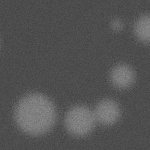

In [353]:
import tifffile as tiff
from PIL import Image              
import numpy as np
from IPython.display import display 
image = (tiff.imread("./data/spots01.tif"))[650:800,650:800] / 255
im = Image.fromarray(np.uint8(image*255))
display(im)

We need the function we defined before to extract the neighborhood values for all pixels.

In [354]:
def getFeatureVectorsFromImage(image, n, reportInterval):    
    neighborsRange = range((-n//2)+1, (n//2)+1)
    height, width = image.shape
    neighborhood = np.zeros(n*n)
    neighborhoods = np.zeros((height*width, n*n), dtype=float)
    print("Extracting the feature vectors.")
    vectorIndex = 0
    for y in range(0, height):
        if y%reportInterval == 0:
            print("\rRow: " + str(y), end="")
        for x in range(0, width):
            featureIndex = 0
            for yRel in neighborsRange:
                for xRel in neighborsRange:
                    yRel = yRel if y+yRel >= 0 and y+yRel < height else -yRel
                    xRel = xRel if x+xRel >= 0 and x+xRel < width else -xRel
                    neighborhood[featureIndex] = image[y+yRel,x+xRel]
                    featureIndex += 1
            neighborhoods[vectorIndex] = neighborhood
            vectorIndex += 1
    print("", end="\n")
    return neighborhoods

We use the function to create the input data for the network.

In [355]:
neighborhoods = getFeatureVectorsFromImage(image, 3, 2)

Extracting the feature vectors.
Row: 148


One example of the input vectors:

In [356]:
print(neighborhoods[400])

[0.30588235 0.30196078 0.29411765 0.28235294 0.31764706 0.3254902
 0.30196078 0.2745098  0.29803922]


We check the result at the position 400 by comparing it to the neighborhood in the image.

In [357]:
from math import ceil
print(neighborhoods[400].reshape(3,3))
print(image[ceil(400/150)-2:ceil(400/150)+1, 400%150-1:400%150+2].reshape(3,3))

[[0.30588235 0.30196078 0.29411765]
 [0.28235294 0.31764706 0.3254902 ]
 [0.30196078 0.2745098  0.29803922]]
[[0.30588235 0.30196078 0.29411765]
 [0.28235294 0.31764706 0.3254902 ]
 [0.30196078 0.2745098  0.29803922]]


We apply the trained model to the input data.

In [358]:
pMap = model.predict(neighborhoods)
print(pMap[400])

[0.00126263]


Since we have scalar result values, we replace the vectors of length 1 by the scalar values, by flattening the probability map.

In [359]:
print(pMap[0:5])
pMap = pMap.flatten()
print(pMap[0:5])

[[0.00196694]
 [0.00160244]
 [0.00165449]
 [0.00110264]
 [0.00132897]]
[0.00196694 0.00160244 0.00165449 0.00110264 0.00132897]


For now the probability map is a linear array containing one result for each of the $150 \times 150$ pixels

In [360]:
pMap.shape

(22500,)

We create a binary map containing the values 0 and 1, by thresholding the probabilities. Thresholding the values will map all values below the threshold to zero and all value equal to or above the threshold to 1.

In [361]:
threshold = 0.45
mask = (pMap>=threshold)*1
print(list(zip(pMap[4010:4015], mask[4010:4015])))
print(mask.shape)

[(0.07982589, 0), (0.28953066, 0), (0.40903202, 0), (0.66775364, 1), (0.76460457, 1)]
(22500,)


We multiply the values in the pMap and the mask by 255, in order to get values that we can save as an 8-bit greyscale image.

In [362]:
mask = mask * 255
pMap = pMap * 255
print(mask[4010:4015])
print(pMap[4010:4015])

[  0   0   0 255 255]
[ 20.355602  73.83032  104.30316  170.27718  194.97417 ]


We reshape mask and pMap to the shape of the input image.

In [363]:
mask = mask.reshape(image.shape)
pMap = pMap.reshape(image.shape)
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

And we convert the values in the matrices to unsigned 8-bit.

In [364]:
mask = mask.astype(np.uint8)
pMap = pMap.astype(np.uint8)
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

We can display them as images now. We also display the input and the ground-truth image.

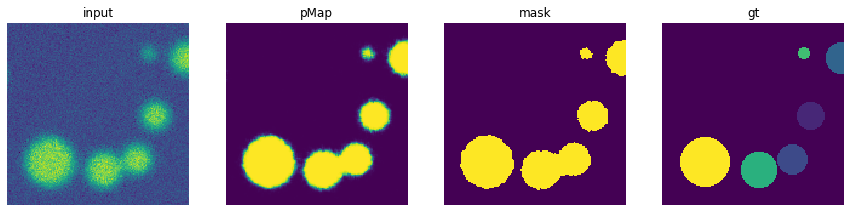

In [373]:
from matplotlib import pyplot as plt
import mpld3
gtImage = (tiff.imread("./data/gt/spots01.tif"))[650:800,650:800] / 255
gtIm = Image.fromarray(np.uint8(gtImage*255))
plt.figure(figsize = (15,12))
for i, pltImage, title in zip(range(1, 5), [im, pMap, mask, gtIm], ['input', 'pMap', 'mask', 'gt']):
    ax = plt.subplot(1,4,i)
    ax.title.set_text(title)
    plt.axis('off')
    plt.imshow(pltImage)

## Saving tiff-images

We use tifffile to save the pMap and the mask. 

```tiff.imwrite(outPath, mask, imagej=True)```

The option ``imagej=True`` saves the numpy array as an ImageJ hyperstack. In our case we only have one channel, 1 timepoint, 2d images, so this option is not necessary, however it can be practical for multidimensional images.